In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from quadratic import quadratic
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device('cpu')

In [3]:
class QuadraticNeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(QuadraticNeuralNet, self).__init__()
        self.fc1 = quadratic.Quadratic(input_size, num_classes) 
        # self.relu = nn.ReLU()
        # self.fc2 = quadratic.Quadratic(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        # out = self.relu(out)
        # out = self.fc2(out)
        return out


class LinearNeuralNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(LinearNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class pointDataset(Dataset):
    """Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Arguments:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, data_tensor, label_tensor):
        assert data_tensor.size(0) == label_tensor.size(0)
        self.data = data_tensor
        self.label = label_tensor


    def __getitem__(self, index):
        return (data[index], label[index])

    def __len__(self):
        return self.data.size(0)


In [4]:
num = 500
input_size = 2
num_classes = 2
num_epochs = 100
batch_size = 40
learning_rate = 0.01

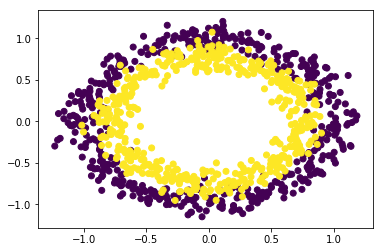

In [18]:
theta = 2*math.pi*torch.rand(size=(num,1))
X1 = torch.cat([(1 + 0.1 * torch.randn(num,1)) * torch.cos(theta),(1 + 0.1*torch.randn(num,1)) * torch.sin(theta)],axis=1)
X2 = torch.cat([(0.75 + 0.1 * torch.randn(num,1)) * torch.cos(theta), (0.75+ 0.1 * torch.randn(num,1)) * torch.sin(theta)],axis=1)

# a = torch.randint(0, 2, size = (num,1))
# X1 = torch.cat([a + 0.1 * torch.randn(num,1), 1-a + 0.1 * torch.randn(num,1)], axis = 1)
# X2 = torch.cat([a + 0.1 * torch.randn(num,1), a + 0.1 * torch.randn(num,1)], axis = 1)

data = torch.cat([X1,X2])
label = torch.cat((torch.zeros(num, dtype=int),torch.ones(num, dtype=int)))
plt.figure()
plt.scatter(data[:,0], data[:,1], c = list(label))
plt.show()

In [31]:
# model = LinearNeuralNet(input_size, 5, num_classes).to(device)
model = QuadraticNeuralNet(input_size, 1, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
dataset = pointDataset(data, label) 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (int(0.8*len(dataset)), int(0.2*len(dataset))))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [33]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 2).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [10/20], Loss: 0.7590
Epoch [1/100], Step [20/20], Loss: 0.7620
Epoch [2/100], Step [10/20], Loss: 0.7275
Epoch [2/100], Step [20/20], Loss: 0.7375
Epoch [3/100], Step [10/20], Loss: 0.6624
Epoch [3/100], Step [20/20], Loss: 0.7282
Epoch [4/100], Step [10/20], Loss: 0.6747
Epoch [4/100], Step [20/20], Loss: 0.6362
Epoch [5/100], Step [10/20], Loss: 0.6115
Epoch [5/100], Step [20/20], Loss: 0.5607
Epoch [6/100], Step [10/20], Loss: 0.5778
Epoch [6/100], Step [20/20], Loss: 0.5600
Epoch [7/100], Step [10/20], Loss: 0.5044
Epoch [7/100], Step [20/20], Loss: 0.5324
Epoch [8/100], Step [10/20], Loss: 0.5046
Epoch [8/100], Step [20/20], Loss: 0.5348
Epoch [9/100], Step [10/20], Loss: 0.4327
Epoch [9/100], Step [20/20], Loss: 0.4515
Epoch [10/100], Step [10/20], Loss: 0.4488
Epoch [10/100], Step [20/20], Loss: 0.4025
Epoch [11/100], Step [10/20], Loss: 0.4266
Epoch [11/100], Step [20/20], Loss: 0.4910
Epoch [12/100], Step [10/20], Loss: 0.4209
Epoch [12/100], Step [20/20],

In [34]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 2).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader), 100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the network on the 5 test images: 95.0 %
